In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath
import auxiliary_library as me

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, formatter={"float":lambda x: str(.001*int(1000*x)) })

In [2]:
N = 7; k_B = 1; temp = 5e-1; ts = np.linspace(0, 10,750)
spin_ops_list = me.one_body_spin_ops(N)
identity_op = spin_ops_list[0][0]

### Heisenberg Hamiltonian
chain_type = "XYZ"; Hamiltonian_paras = [.2, .15, .1, 1.]
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)

rho_tolerance = (-.5 * H_H).expm()
rho_tolerance = rho_tolerance/rho_tolerance.tr()

sigma_tolerance = (-.4 * H_H).expm()
sigma_tolerance = sigma_tolerance/sigma_tolerance.tr()

### classical operators 

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")

print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))
basis = [identity_op, cl_ops["x_op"]]

Are all the operators Hermitian?: True


In [3]:
rhos = []
    
def callback(t, rhot):
    #global rho
    global rhos
    rho = rhot
    rhos.append(rhot)
    
    rhos = []    
    def callbacks(t, rhot):
        global rho
        global rhos
        rho = rhot
        rhos.append(rhot)

def exact_evolution(Hamiltonian, rho0, ts, obs):
    approx_exp_vals = []
    for t in ts:
        qutip.mesolve(Hamiltonian, rho0=rho0, tlist=np.linspace(t-1,t,1), c_ops=None, e_ops=callback)
        #newobs = [qutip.expect(rho, op) for op in obs]
        #approx_exp_vals.append(newobs)
    result = {}
    result["times"] = ts
    #result["averages"] = np.array(approx_exp_vals)
    result["state ev"] = rhos
    return result

In [3]:
def d_depth_proj_ev(initial_d_list, seed_ops_list, size, Hamiltonian, basis, cl_ops_list, temp, ts,
                    observables, visualize_H_evs, visualization_nonherm, visualize_expt_vals):
    
    ### building reference states and testing it
    start_time_1 = time.time()
    K_ref, rho_ref = me.build_reference_state(size = size, temp = temp, Hamiltonian = Hamiltonian,
                                       lagrange_op = cl_ops["n_oc_op"], lagrange_mult = .1, svd = True)
    basis_incursive = me.vectorized_recursive_basis(depth_list = initial_d_list, 
                                                    seed_ops_list = seed_ops_list,
                                                    Hamiltonian = Hamiltonian, rho0 = rho_ref)
    basis_orth = me.base_orth(ops = basis_incursive, rho0 = rho_ref, sc_prod = me.HS_inner_prod_r, 
                              visualization = False)
    
    ### test 2
    basis_orth, gram_matrix = me.basis_orthonormality_check(basis = basis_orth, 
                                                            rho0 = rho_ref, sc_prod = me.HS_inner_prod_r)
    
    ### constructing the initial state and H-tensor
    
    phi0, rho0 = me.build_rho0_from_basis(basis = basis_orth)
    Hijtensor = qutip.Qobj(me.H_ij_matrix(Hamiltonian = Hamiltonian, basis = basis_orth, 
                                           rho0 = rho_ref, sc_prod = me.HS_inner_prod_r)[1])
    if visualize_H_evs: 
        me.visz_H_tensor_evs(Htensor = Hijtensor)
        
    ### constructing the coefficient arrays and the physical states
    rhot_list = me.semigroup_phit_and_rhot_sol(phi0 = phi0, rho0 = rho0, Htensor = Hijtensor,
                                               ts = ts, basis = basis_orth)

    ### test 3
    herm_rhot_list = me.semigroup_rhos_test(rho_list = rhot_list, 
                                            visualization_nonherm = visualization_nonherm, ts = ts)
    
    ### Projected solution
    
    res_proj_ev = [np.array([qutip.expect(obs, rhot) for rhot in herm_rhot_list]) for obs in observables]
    print("Proj ev runtime = ", time.time() - start_time_1)
    
    ### Exact solution 
    
    start_time_2 = time.time()
    #res_exact = exact_evolution(Hamiltonian, rho0, ts, observables)
    #res_exact = qutip.mesolve(Hamiltonian, rho0=rho0, tlist=ts, c_ops=None, e_ops = observables)
    
    res_exact = qutip.mesolve(Hamiltonian, rho0=rho0, tlist=ts, 
                                   c_ops=None, e_ops=observables)
    res_exact_B = qutip.mesolve(Hamiltonian, rho0=rho0, tlist=ts, 
                                   c_ops=None, e_ops=None)
    
    print("Exact ev runtime = ", time.time() - start_time_2)
    
    if visualize_expt_vals:
        z = ts[:-1]
        fig3, ax3 = plt.subplots()
        ax3.plot(z, res_proj_ev[0], label = "Manifold-proj")
        ax3.plot(z, res_exact.expect[0][:-1], label = "Exact")
        ax3.legend(loc=0)
        ax3.set_title("Expected values for x_op - Exact v. Proj. ev. ")
        
        fig4, ax4 = plt.subplots()
        ax4.plot(z, res_proj_ev[1], label = "Manifold-proj")
        ax4.plot(z, res_exact.expect[1][:-1], label = "Exact")
        ax4.legend(loc = 0)
        ax4.set_title("Expected values for n_oc_op - Exact v. Proj. ev.")
        
        fig5, ax5 = plt.subplots()
        ax5.plot(z, res_proj_ev[2], label = "Manifold-proj")
        ax5.plot(z, res_exact.expect[2][:-1], label = "Exact")
        ax5.legend(loc = 0)
        ax5.set_title("Expected values for magnetization - Exact v. Proj. ev.")
    
    #max_diff_x = max(res_exact["averages"][:,0][:-1] - res_proj_ev[0])
    #max_diff_n_oc = max(res_exact["averages"][:,1][:-1] - res_proj_ev[1])
    #print(max_diff_x, max_diff_n_oc)
    
    if True:
        bures_exact_approx_list = [me.bures(herm_rhot_list[t], res_exact_B.states[t]) for t in range(len(herm_rhot_list))]
        relentropy_exact_approx_list = [me.rel_entropy(herm_rhot_list[t], res_exact_B.states[t]) for t in range(len(herm_rhot_list))]
        relentropy_exact_approx_list_prime = [me.rel_entropy(res_exact_B.states[t], herm_rhot_list[t]) for t in range(len(herm_rhot_list))]
        fig6, ax6 = plt.subplots()
        ax6.plot(ts[:-1], bures_exact_approx_list, label = "Bures metric")
        ax6.plot(ts[:-1], relentropy_exact_approx_list, label = "Relative entropy - Proj. v. Exact")
        ax6.plot(ts[:-1], relentropy_exact_approx_list_prime, label = "Relative entropy - Exact v. Proj.")
        ax6.legend(loc=0)
        ax6.set_title("Metrics - Exact and Proj. ev - d = 3 ops")
    
    return rho0, herm_rhot_list, res_exact, res_exact_B, res_proj_ev

Not mean-normalized operator at 0 -th level
-5.3625973198324515e-05
Not mean-normalized operator at 1 -th level
-0.7859396077362002
Not mean-normalized operator at 2 -th level
-2.778268066994105e-19j
Not mean-normalized operator at 3 -th level
-0.6183687885149934
The 3 -th operator is not normalized 

Not mean-normalized operator at 4 -th level
-4.828087799349512e-20j
Not mean-normalized operator at 6 -th level
-0.00017420184408900585
Not mean-normalized operator at 7 -th level
-0.0001742018440180331
The 7 -th operator is not normalized 

Not mean-normalized operator at 8 -th level
1.6601845766184287e-19j
Not mean-normalized operator at 9 -th level
-2.2836349015379785e-05
Not mean-normalized operator at 10 -th level
1.249373597200093e-20j
Not mean-normalized operator at 11 -th level
-1.3432604597428833e-05
Not mean-normalized operator at 12 -th level
-2.212397137573048e-05
Not mean-normalized operator at 13 -th level
-2.2123971375889208e-05
Not mean-normalized operator at 14 -th level


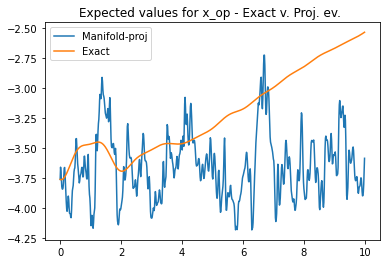

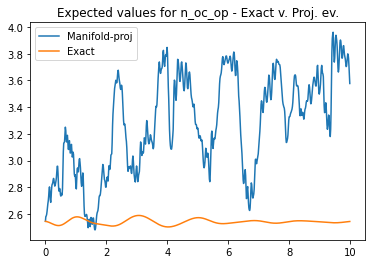

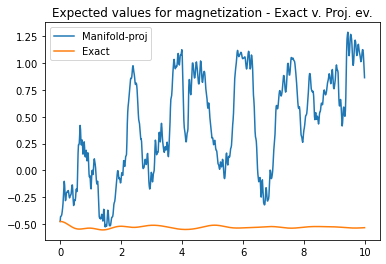

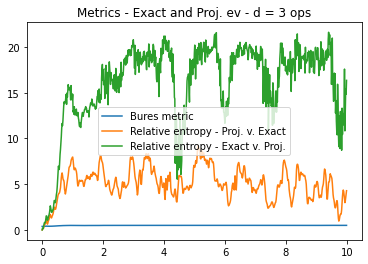

In [5]:
initial_d_list = [0, 5, 5, 50]
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d_list = initial_d_list,
                              seed_ops_list = seed_ops_list, size = N,
                              Hamiltonian = H_H, basis = basis, 
                              cl_ops_list = cl_ops, temp = temp, ts = ts,
                              observables = observables, visualize_H_evs = False, 
                              visualization_nonherm = False, visualize_expt_vals = True)

Not mean-normalized operator at 0 -th level
-5.3625973198324515e-05
Not mean-normalized operator at 1 -th level
-0.7859396077362002
Not mean-normalized operator at 2 -th level
-2.778268066994105e-19j
Not mean-normalized operator at 3 -th level
-0.6183687885149934
The 3 -th operator is not normalized 

Not mean-normalized operator at 4 -th level
-4.828087799349512e-20j
Not mean-normalized operator at 6 -th level
7.623296525288703e-21j
Not mean-normalized operator at 8 -th level
-4.277516383634217e-20j
Not mean-normalized operator at 10 -th level
-1.8211208365967457e-20j
Not mean-normalized operator at 12 -th level
-2.202285662861181e-20j
Not mean-normalized operator at 14 -th level
1.6940658945086007e-20j
Not mean-normalized operator at 16 -th level
-2.879912020664621e-20j
Not mean-normalized operator at 18 -th level
1.0164395367051604e-20j
Not mean-normalized operator at 19 -th level
-2.643054379154611e-05
Not mean-normalized operator at 20 -th level
1.1858461261560205e-20j
Not mean-no

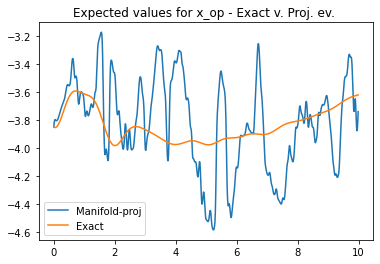

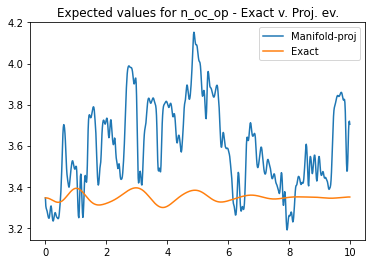

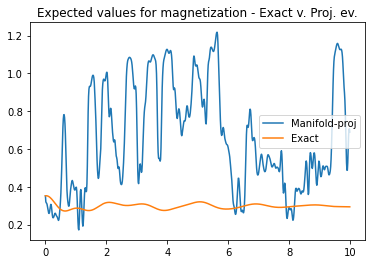

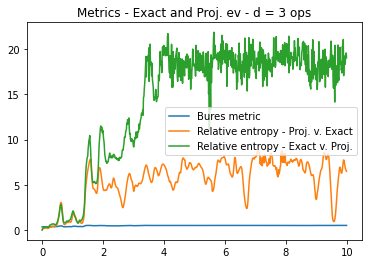

In [6]:
initial_d_list = [0, 50, 5, 5]
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d_list = initial_d_list,
                              seed_ops_list = seed_ops_list, size = N,
                              Hamiltonian = H_H, basis = basis, 
                              cl_ops_list = cl_ops, temp = temp, ts = ts,
                              observables = observables, visualize_H_evs = False, 
                              visualization_nonherm = False, visualize_expt_vals = True)

Not mean-normalized operator at 0 -th level
-5.3625973198324515e-05
Not mean-normalized operator at 1 -th level
-0.7859396077362002
Not mean-normalized operator at 2 -th level
-2.778268066994105e-19j
Not mean-normalized operator at 3 -th level
-0.6183687885149934
The 3 -th operator is not normalized 

Not mean-normalized operator at 4 -th level
-4.828087799349512e-20j
Not mean-normalized operator at 6 -th level
7.623296525288703e-21j
Not mean-normalized operator at 8 -th level
-4.277516383634217e-20j
Not mean-normalized operator at 10 -th level
-1.8211208365967457e-20j
Not mean-normalized operator at 12 -th level
-2.202285662861181e-20j
Not mean-normalized operator at 14 -th level
1.6940658945086007e-20j
Not mean-normalized operator at 16 -th level
-0.00016818527382758512
Not mean-normalized operator at 18 -th level
2.371692252312041e-20j
Not mean-normalized operator at 19 -th level
-2.7212283049237026e-05
Not mean-normalized operator at 20 -th level
1.1434944787933055e-20j
Not mean-no

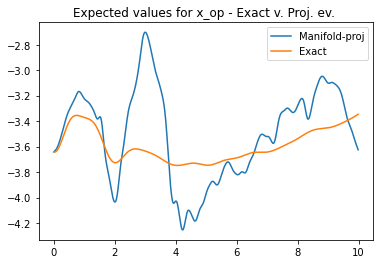

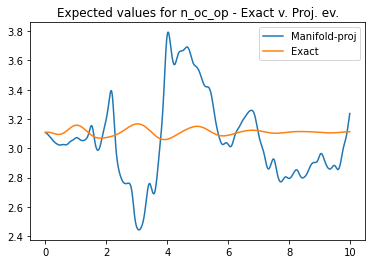

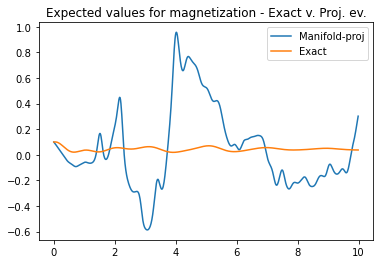

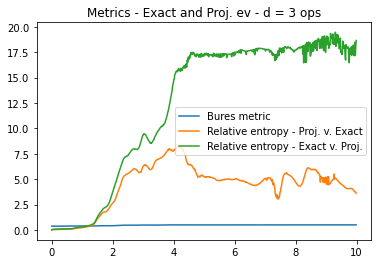

In [14]:
initial_d_list = [0, 15, 5, 5]
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d_list = initial_d_list,
                              seed_ops_list = seed_ops_list, size = N,
                              Hamiltonian = H_H, basis = basis, 
                              cl_ops_list = cl_ops, temp = temp, ts = ts,
                              observables = observables, visualize_H_evs = False, 
                              visualization_nonherm = False, visualize_expt_vals = True)

Not mean-normalized operator at 0 -th level
-5.3625973198324515e-05
Not mean-normalized operator at 1 -th level
-0.7859396077362002
Not mean-normalized operator at 2 -th level
-2.778268066994105e-19j
Not mean-normalized operator at 3 -th level
-0.6183687885149934
The 3 -th operator is not normalized 

Not mean-normalized operator at 4 -th level
-4.828087799349512e-20j
Not mean-normalized operator at 6 -th level
7.623296525288703e-21j
Not mean-normalized operator at 8 -th level
-4.277516383634217e-20j
Not mean-normalized operator at 10 -th level
-1.8211208365967457e-20j
Not mean-normalized operator at 12 -th level
-2.202285662861181e-20j
Not mean-normalized operator at 14 -th level
1.6940658945086007e-20j
Not mean-normalized operator at 16 -th level
-2.879912020664621e-20j
Not mean-normalized operator at 18 -th level
1.0164395367051604e-20j
Not mean-normalized operator at 19 -th level
-2.643054379154611e-05
Not mean-normalized operator at 20 -th level
1.1858461261560205e-20j
Not mean-no

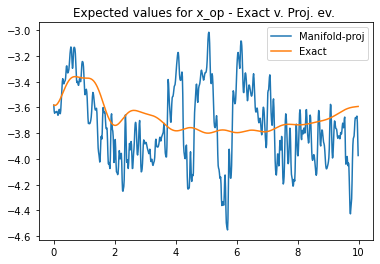

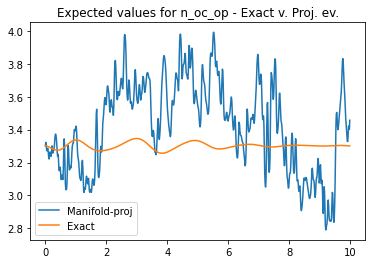

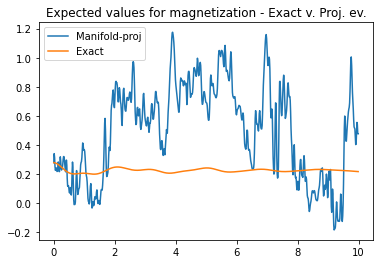

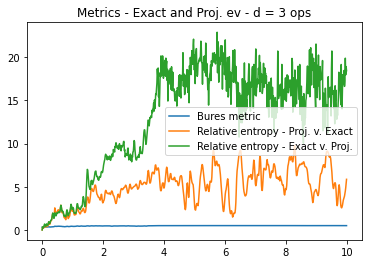

In [5]:
initial_d_list = [0, 30, 30, 15]
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d_list = initial_d_list,
                              seed_ops_list = seed_ops_list, size = N,
                              Hamiltonian = H_H, basis = basis, 
                              cl_ops_list = cl_ops, temp = temp, ts = ts,
                              observables = observables, visualize_H_evs = False, 
                              visualization_nonherm = False, visualize_expt_vals = True)

The 3 -th operator is not normalized 

Not mean-normalized operator at 5 -th level
9.23419971279437e-06
Not mean-normalized operator at 7 -th level
1.3638113090597387e-05
Not mean-normalized operator at 9 -th level
2.1751867609336346e-05
Not mean-normalized operator at 11 -th level
2.177365419787111e-05
Not mean-normalized operator at 13 -th level
2.029828272775481e-05
Not mean-normalized operator at 15 -th level
2.6036477539054855e-05
Not mean-normalized operator at 17 -th level
2.5999897296329327e-05
Not mean-normalized operator at 21 -th level
2.6631050649987293e-05
Not mean-normalized operator at 25 -th level
2.5699665517794207e-05
Not mean-normalized operator at 29 -th level
1.403838845433626e-05
Not mean-normalized operator at 38 -th level
6.763689406460429e-06
Not mean-normalized operator at 42 -th level
4.715061183819348e-06
Not mean-normalized operator at 44 -th level
2.940679250854858e-07
Not mean-normalized operator at 48 -th level
1.7423488163144672e-07
Not mean-normalized 

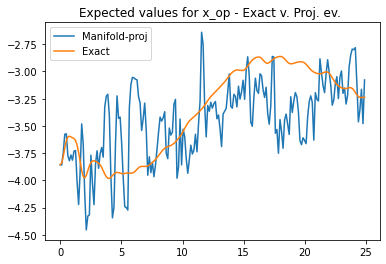

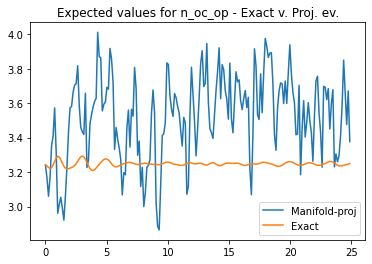

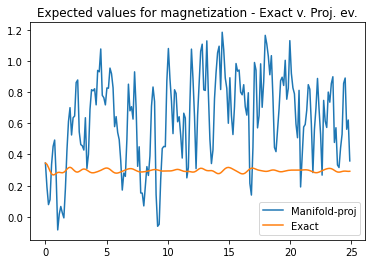

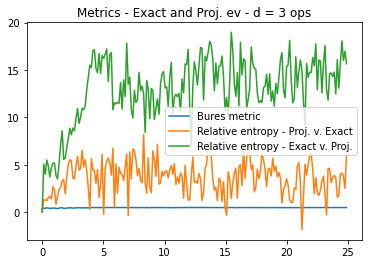

In [15]:
initial_d_list = [0, 30, 30, 15]
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d_list = initial_d_list,
                              seed_ops_list = seed_ops_list, size = N,
                              Hamiltonian = H_H, basis = basis, 
                              cl_ops_list = cl_ops, temp = temp, ts = ts,
                              observables = observables, visualize_H_evs = False, 
                              visualization_nonherm = False, visualize_expt_vals = True)

The 3 -th operator is not normalized 

Not mean-normalized operator at 5 -th level
9.23419971279437e-06
Not mean-normalized operator at 7 -th level
1.3638113090597387e-05
Not mean-normalized operator at 9 -th level
2.1751867609336346e-05
Not mean-normalized operator at 11 -th level
2.177365419787111e-05
Not mean-normalized operator at 13 -th level
2.029828272775481e-05
Not mean-normalized operator at 15 -th level
2.6036477539054855e-05
Not mean-normalized operator at 17 -th level
0.00016818527383028609
Not mean-normalized operator at 25 -th level
3.0213299786951086e-06
Not mean-normalized operator at 27 -th level
3.621776834254731e-06
Not mean-normalized operator at 31 -th level
1.3756403206030652e-06
Not mean-normalized operator at 41 -th level
4.92367236606939e-06
Not mean-normalized operator at 43 -th level
5.4196998533226435e-06
Not mean-normalized operator at 47 -th level
5.120880706925525e-06
The basis is orthonormal and hermitian
rho0: not positive defined
Proj ev runtime =  191

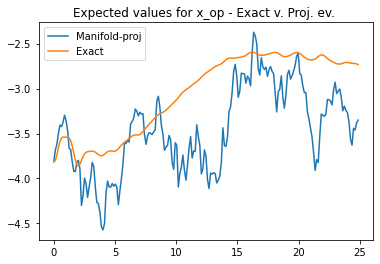

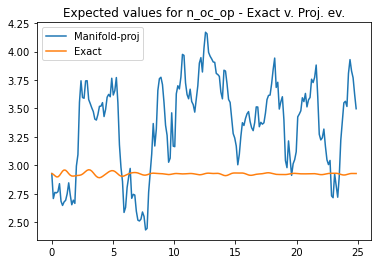

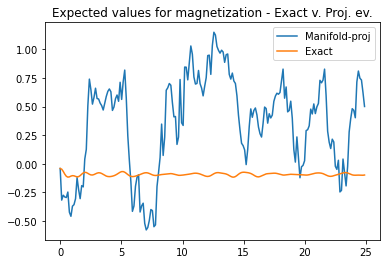

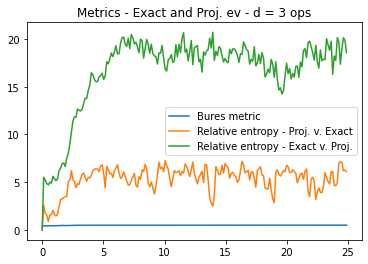

In [14]:
initial_d_list = [0, 15, 15, 15]
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d_list = initial_d_list,
                              seed_ops_list = seed_ops_list, size = N,
                              Hamiltonian = H_H, basis = basis, 
                              cl_ops_list = cl_ops, temp = temp, ts = ts,
                              observables = observables, visualize_H_evs = False, 
                              visualization_nonherm = False, visualize_expt_vals = True)

Not mean-normalized operator at 3 -th level
0.49434728652880655
Not mean-normalized operator at 5 -th level
0.019708724470903983
Not mean-normalized operator at 7 -th level
0.011416769197054968
The basis is orthonormal and hermitian
rho0: not positive defined
Proj ev runtime =  8.963070392608643
Exact ev runtime =  6.059684991836548


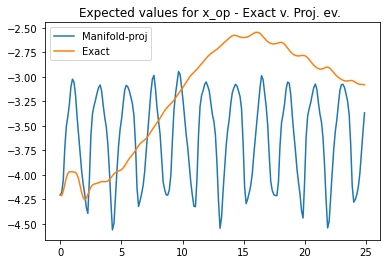

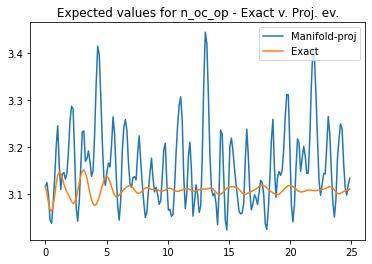

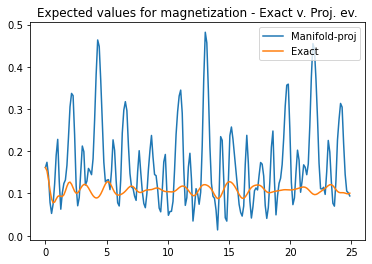

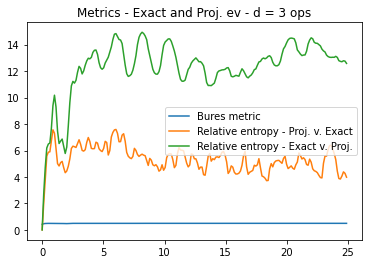

In [11]:
initial_d_list = [0, 2, 5, 1]
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d_list = initial_d_list,
                              seed_ops_list = seed_ops_list, size = N,
                              Hamiltonian = H_H, basis = basis, 
                              cl_ops_list = cl_ops, temp = temp, ts = ts,
                              observables = observables, visualize_H_evs = False, 
                              visualization_nonherm = False, visualize_expt_vals = True)

The basis is orthonormal and hermitian
Proj ev runtime =  2.004918336868286
Proj ev runtime =  0.460735559463501


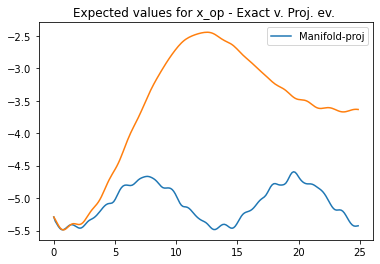

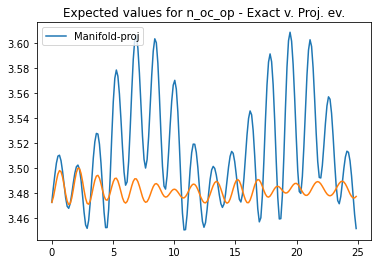

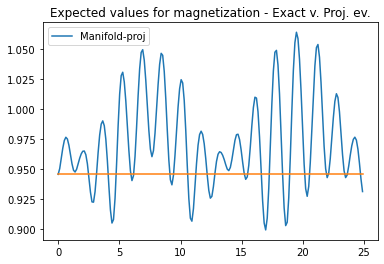

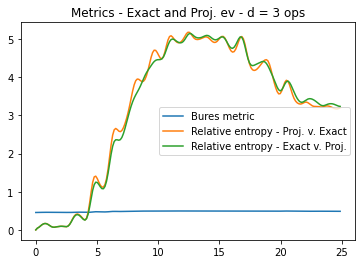

In [142]:
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d = 7, seed_op = cl_ops["x_op"], size = N,
                                                               Hamiltonian = H_H, basis = basis, 
                                                               cl_ops_list = cl_ops, temp = temp, ts = ts,
                                                              observables = observables, visualize_H_evs = False, 
                                                               visualization_nonherm = False, visualize_expt_vals = True)

Not mean-normalized operator at 28 -th level
0.04808133104304273
Not mean-normalized operator at 32 -th level
0.04817525694187612
Not mean-normalized operator at 36 -th level
0.04831544629838307
Not mean-normalized operator at 40 -th level
0.04841130413332223
Not mean-normalized operator at 44 -th level
0.04847045600416262
Not mean-normalized operator at 48 -th level
0.04850569210852944
Not mean-normalized operator at 52 -th level
0.0485262510244995
Not mean-normalized operator at 56 -th level
0.04853805033286487
Not mean-normalized operator at 60 -th level
0.0485447253872421
Not mean-normalized operator at 64 -th level
0.048548454108872124
Not mean-normalized operator at 68 -th level
0.04855051455339327
Not mean-normalized operator at 72 -th level
0.04855164293699068
Not mean-normalized operator at 76 -th level
0.04855225643727258
Not mean-normalized operator at 80 -th level
0.04855258813203684
Not mean-normalized operator at 84 -th level
0.04855276671848015
Not mean-normalized operat

Proj ev runtime =  440.382675409317
Exact ev runtime =  1.6049449443817139


C:\Users\tomas\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\tomas\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\tomas\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


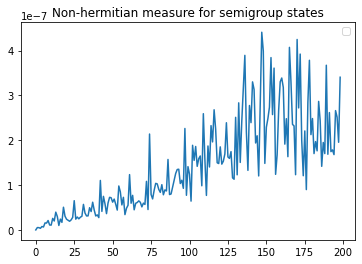

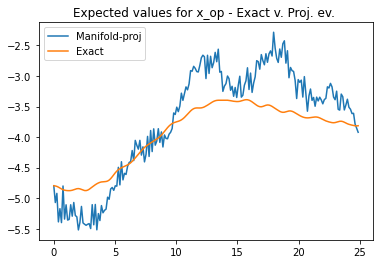

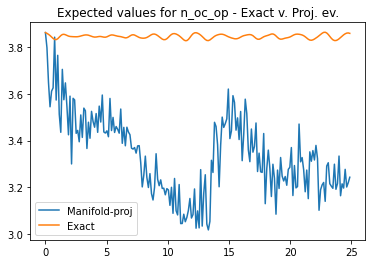

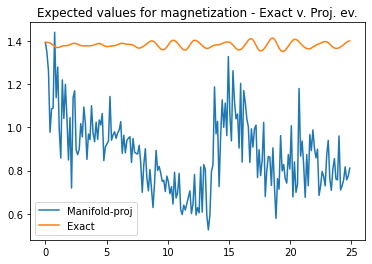

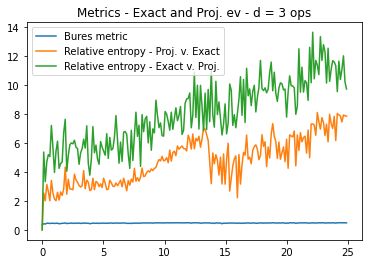

In [9]:
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d = 250, seed_op = cl_ops["x_op"], size = N,
                                                               Hamiltonian = H_H, basis = basis, 
                                                               cl_ops_list = cl_ops, temp = temp, ts = ts,
                                                              observables = observables, visualize_H_evs = False, 
                                                               visualization_nonherm = True, visualize_expt_vals = True)

# Cosas para testear:

1. dos operadores con índices de recursividad d1 y d2, le ganan a un único operador de índice (d1+d2)?
2. como cuantificar el "poder" o el operador que más domina en la expansión? lambda más grande?
3. tiene sentido usar el algoritmo de Strassen acá?
4. plotear Bures y entropías relativas entre estados
5. intentar con funciones de dos puntos y Neels/Magnetizations